In [1]:
from PIL import Image, ImageOps, ImageFilter
from skimage.measure import label, regionprops
from skimage.morphology import square, closing, opening
from skimage.segmentation import clear_border
from skimage.filters import gaussian
from scipy import stats
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display
import os
%matplotlib inline

In [2]:
color_images = [ Image.open("D:/7 семестр/ЦОСИ/hard/" + im) for im in os.listdir("D:/7 семестр/ЦОСИ/hard")]

In [3]:
def plot_im(data, gray = 0):
    fig, ax1 = plt.subplots(1,len(data), figsize=(22,3))
    for num, im in enumerate(data):
        if gray:
            ax1[num].imshow(im, cmap='gray')
        else:
            ax1[num].imshow(im)
    plt.show()

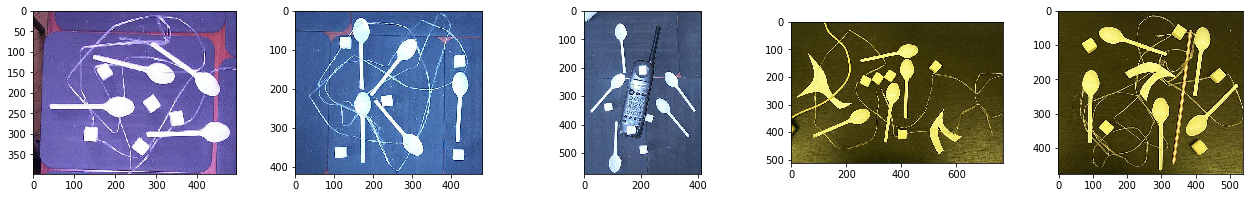

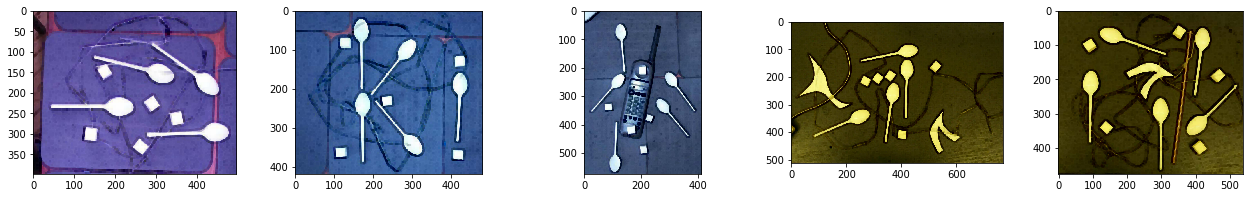

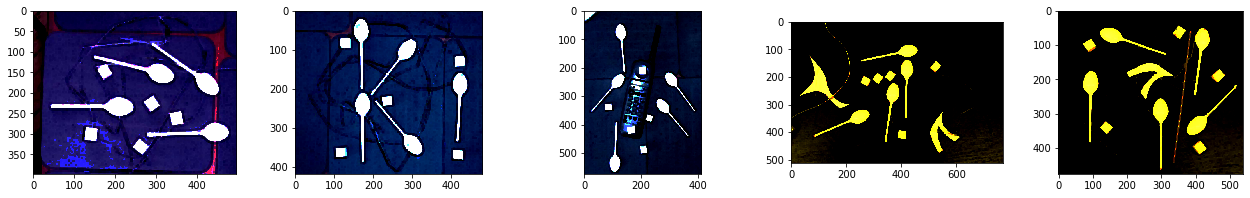

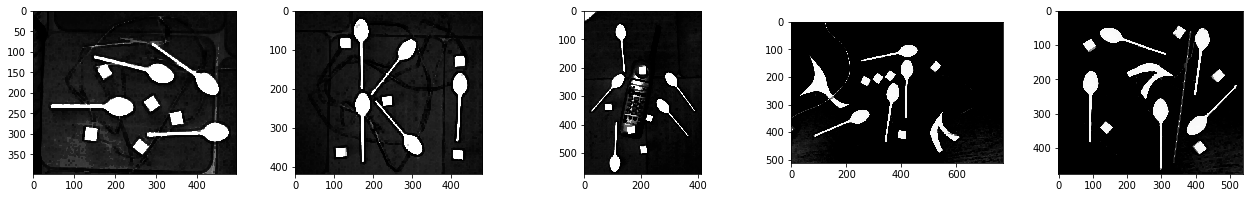

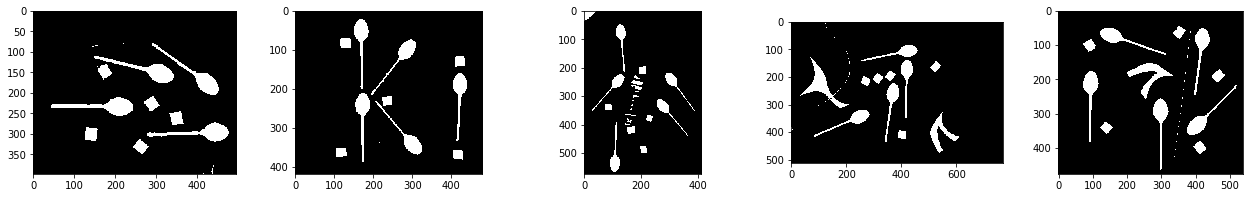

In [4]:
plot_im(color_images)
'''
#высокочастотный фильтр
km2 = (
    1, 1, 1,
    1, -3, 1,
    1, 1, 1,
      )
k2 = ImageFilter.Kernel(size=(3, 3), kernel=km2, scale=sum(km2), offset=0)
images = [im.filter(k2) for im in color_images]
plot_im(images)

images = [im.filter(ImageFilter.UnsharpMask(radius=3, percent=250, threshold=3)) for im in images]
plot_im(images)'''


images = [im.filter(ImageFilter.MinFilter(5)) for im in color_images]
plot_im(images)




#выделение белых мест для контраста
images = [Image.eval(im, lambda px: px-70 if px < 180 else 255) for im in images]
plot_im(images)



#перевод в чёрно-белое 
images = [ImageOps.grayscale(im) for im in images]
plot_im(images, 1)

'''
#размывка
gauss = ImageFilter.GaussianBlur(radius=2)
images = [im.filter(gauss) for im in images]
plot_im(images, 1)
'''

#перевод в бинарное
raw_bin_images = [Image.eval(im, lambda px: 255 if px > 120 else 0) for im in images]
plot_im(raw_bin_images, 1)


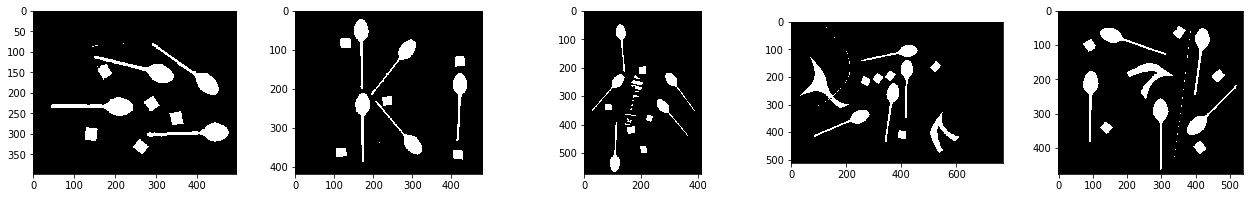

In [5]:
# Remove small white regions
#bin_images = [opening(im, square(2)) for im in bin_images]
#plot_im(bin_images, 1)

# Remove small black hole
bin_images = [closing(im, square(3)) for im in raw_bin_images]
bin_images = [clear_border(np.array(im)) for im in bin_images]
plot_im(bin_images, 1)

In [6]:
label_images = [label(im, neighbors = 4) for im in bin_images]
features = pd.DataFrame(columns=['Image', 'Object', 'Area', 'Perimeter', \
                                 'Compactness', 'Major_axis_length','Minor_axis_length', 'Eccentricity'])
items = []
detection = []
for n_im, im in enumerate(label_images):
    i = 0
    region_d = []
    for region in regionprops(im):
        if (region.minor_axis_length > 15):
            features = features.append({'Image': n_im,\
                                        'Object': i, \
                                        'Area':region.area, \
                                        'Perimeter':region.perimeter, \
                                        'Major_axis_length': region.major_axis_length,\
                                        'Minor_axis_length': region.minor_axis_length,\
                                        'Compactness': ((region.perimeter**2)/region.area), \
                                        'Eccentricity':region.eccentricity}, ignore_index=True) 
            region_d += [list(region.bbox)] 
            i += 1
    detection += [region_d]
    items += [i]
print(items)


D:\Anaconda\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
D:\Anaconda\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


[9, 10, 10, 11, 11]


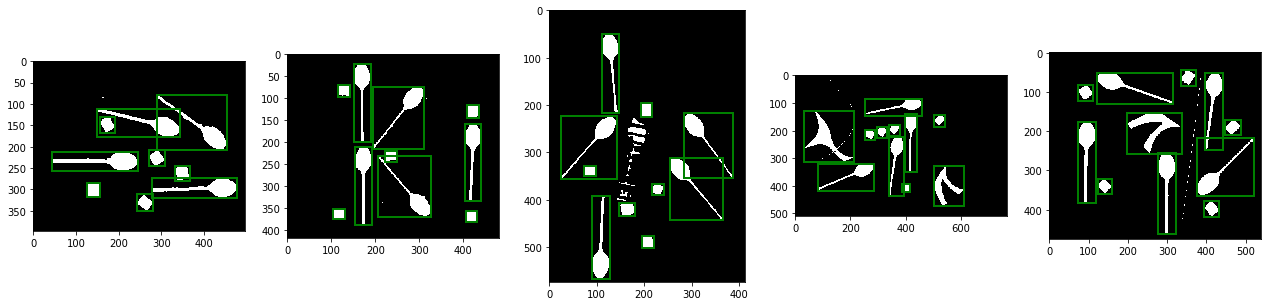

In [7]:
fig, ax1 = plt.subplots(1,len(images), figsize=(22,5))
for num, im in enumerate(bin_images):
    ax1[num].imshow(im, cmap='gray')
    for item in detection[num]:
        rect = mpatches.Rectangle((item[1], item[0]), item[3] - item[1], item[2] - item[0],\
                                  fill=False, edgecolor='green', linewidth=2)
        ax1[num].add_patch(rect)
    
plt.show()

[array([1, 1, 0, 0, 1, 0, 1, 0, 0]), array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1]), array([1, 0, 1, 1, 1, 0, 0, 1, 0, 0]), array([3, 2, 3, 0, 0, 0, 0, 3, 3, 1, 0]), array([0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0])]


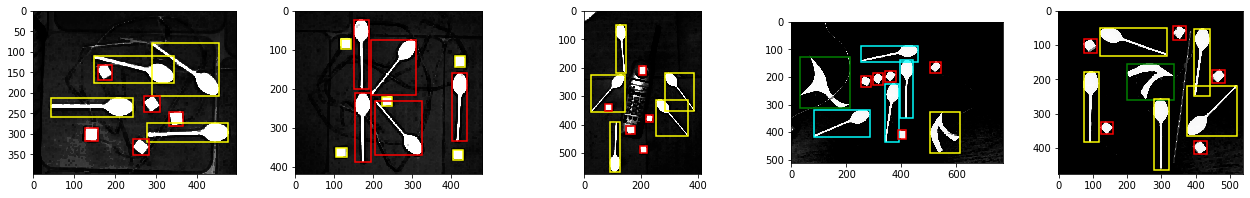

In [44]:
features_list_all = ['Area', 'Perimeter', 'Compactness', 'Major_axis_length','Minor_axis_length', 'Eccentricity']
clusters = [2, 2, 2, 4, 3]
colors = np.array(['red', 'yellow', 'green', 'cyan', 'blue', 'purple'])
km_labels = []
fig, ax1 = plt.subplots(1,len(images), figsize=(22,3))
for num, im in enumerate(images):
    ax1[num].imshow(im, cmap='gray')
    km = KMeans(n_clusters=clusters[num], random_state=1)
    km.fit(features[features["Image"] == num][features_list])
    km_labels += [km.labels_]
    for n_item, item in enumerate(detection[num]):
        rect = mpatches.Rectangle((item[1], item[0]), item[3] - item[1], item[2] - item[0],\
                                  fill=False, edgecolor=colors[km.labels_[n_item]], linewidth=1.5)
        ax1[num].add_patch(rect)
    
print(km_labels)
plt.show()


<function matplotlib.pyplot.show>

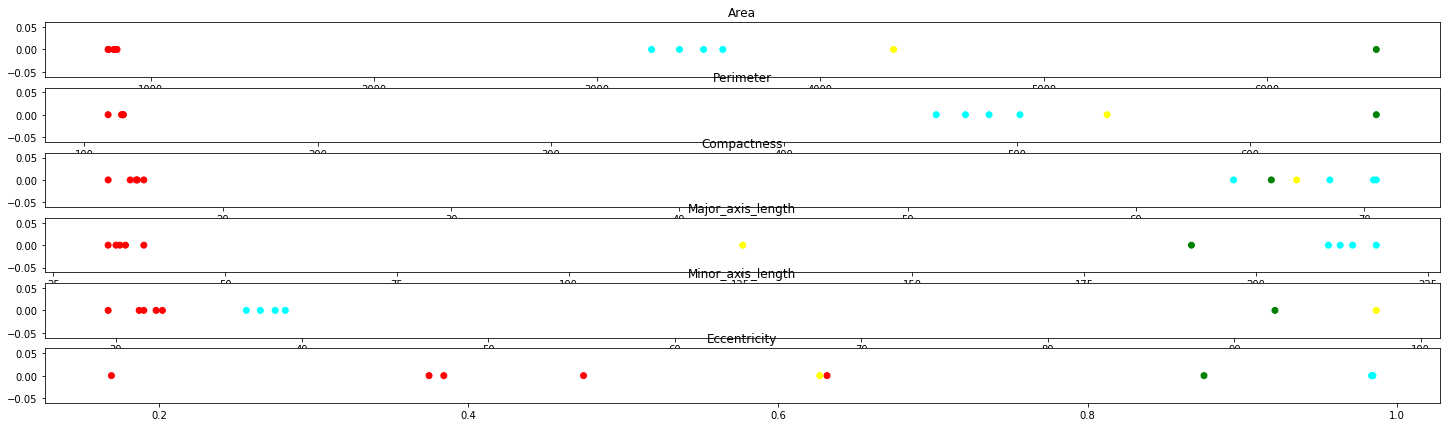

In [45]:
fig, ax = plt.subplots(len(features_list_all), 1, figsize=(25,7))
for i in range(len(features_list_all)):
    ax[i].scatter(features[features['Image'] == 3][features_list_all[i]], [0]*items[3], c = colors[km_labels[3]])
    ax[i].title.set_text(features_list_all[i])
plt.show

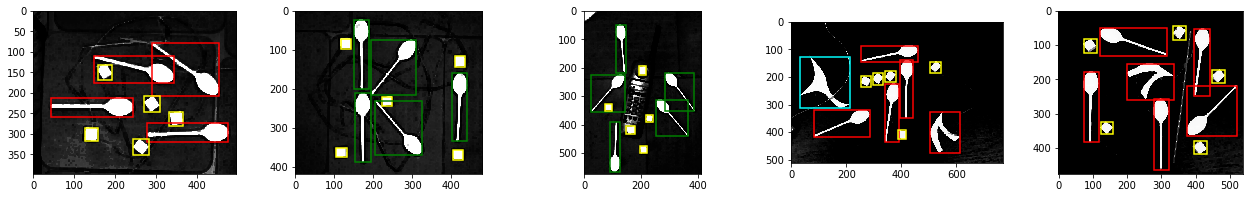

In [49]:
features_list = ['Area', 'Perimeter','Minor_axis_length', 'Major_axis_length']
clusters = [2, 2, 2, 4, 3]
colors = np.array(['red', 'yellow', 'green', 'cyan', 'blue', 'purple'])

km_all = KMeans(n_clusters=4, random_state=1)
km_all.fit(features[features_list])
    
fig, ax1 = plt.subplots(1,len(images), figsize=(22,3))
n_item = 0
for num, im in enumerate(images):
    ax1[num].imshow(im, cmap='gray')
    for item in detection[num]:
        rect = mpatches.Rectangle((item[1], item[0]), item[3] - item[1], item[2] - item[0],\
                                  fill=False, edgecolor=colors[km_all.labels_[n_item]], linewidth=1.5)
        ax1[num].add_patch(rect)
        n_item += 1
    
plt.show()

<function matplotlib.pyplot.show>

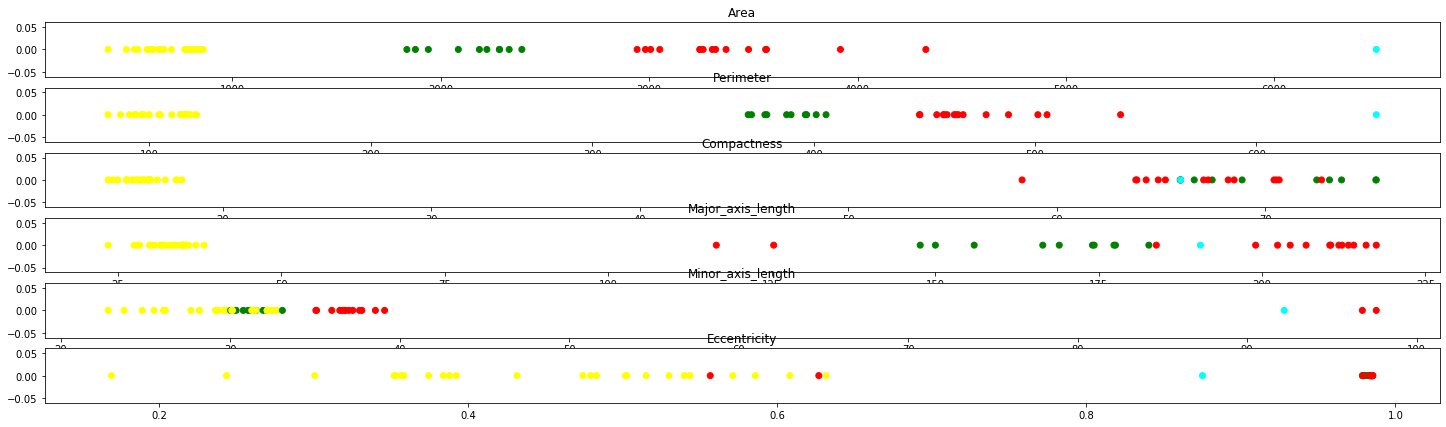

In [47]:
fig, ax = plt.subplots(len(features_list_all), 1, figsize=(25,7))
for i in range(len(features_list_all)):
    ax[i].scatter(features[features_list_all[i]], [0]*sum(items), c = colors[km_all.labels_])
    ax[i].title.set_text(features_list_all[i])
plt.show